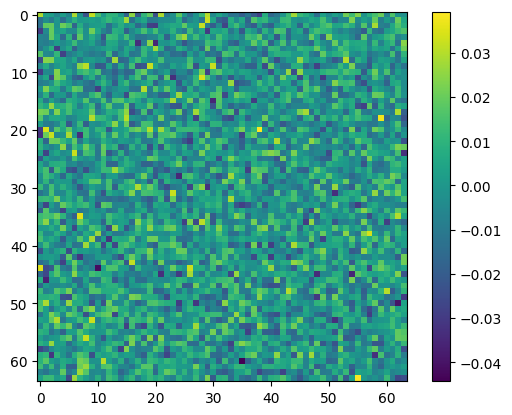

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

0.13972670372197804


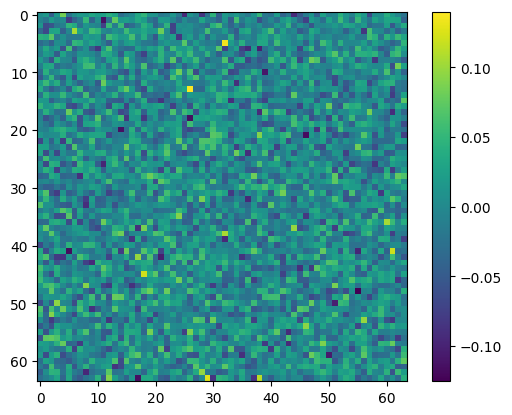

: 

In [20]:
a = np.random.normal(0, 0.035, (64, 64))
#plt.imshow(np.random.normal(0, 0.0125, (64, 64))) # 5000h normalisation
plt.imshow(a) # 1000h normalisation
print(np.max(a))
plt.colorbar()

<class 'numpy.float32'>


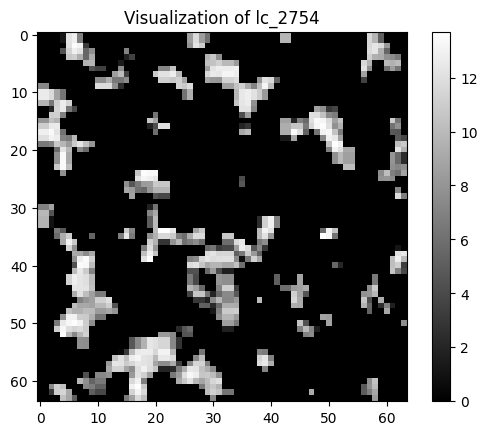

In [5]:
data = np.load('/workspace/arrays_lc_2D.npz')

# Extract one array by its key. For example, using 'lc_2754'
# Assuming 'lc_2754' is the key for one of the arrays
array = data['lc_2754']
print(type(array[0,0]))

# Visualize the array using matplotlib
plt.imshow(array, cmap='gray')  # 'cmap' sets the color map. 'gray' is commonly used for single-channel images
plt.colorbar()  # Optionally add a colorbar to indicate the scale
plt.title('Visualization of lc_2754')
plt.show()

In [6]:
# Initialize a list to hold the noisy versions of the current array
input_data = []
labels = []
labels_binary = []

for i, key in enumerate(data.files[::5]):
    # Access the array
    original_array = data[key]/1000


    # Generate 100 versions with random Gaussian noise added
    for _ in range(100):
        # Generate random Gaussian noise with mean=0 and std=1
        # Note: You can adjust the mean and std according to your needs
        noise = np.random.normal(0, 0.0125, original_array.shape)
        
        # Add the noise to the original array
        noisy_array = original_array + noise

        min_val_combined = noisy_array.min()
        max_val_combined = noisy_array.max()
        normalized_combined_array = (noisy_array - min_val_combined) / (max_val_combined - min_val_combined)

        normalized_label = (original_array - min_val_combined) / (max_val_combined - min_val_combined)
        asd = (original_array - min_val_combined) / (max_val_combined - min_val_combined)

        threshold = (np.max(normalized_label) + np.min(normalized_label))/2 - 0.05*(np.max(normalized_label))
        normalized_label[normalized_label >= threshold] = 1.0
        normalized_label[normalized_label < threshold] = 0.0
        
        # Append the noisy version to the list
        input_data.append(normalized_combined_array)
        labels.append(asd)
        labels_binary.append(normalized_label)

In [7]:
np.shape(input_data[0])

(64, 64)

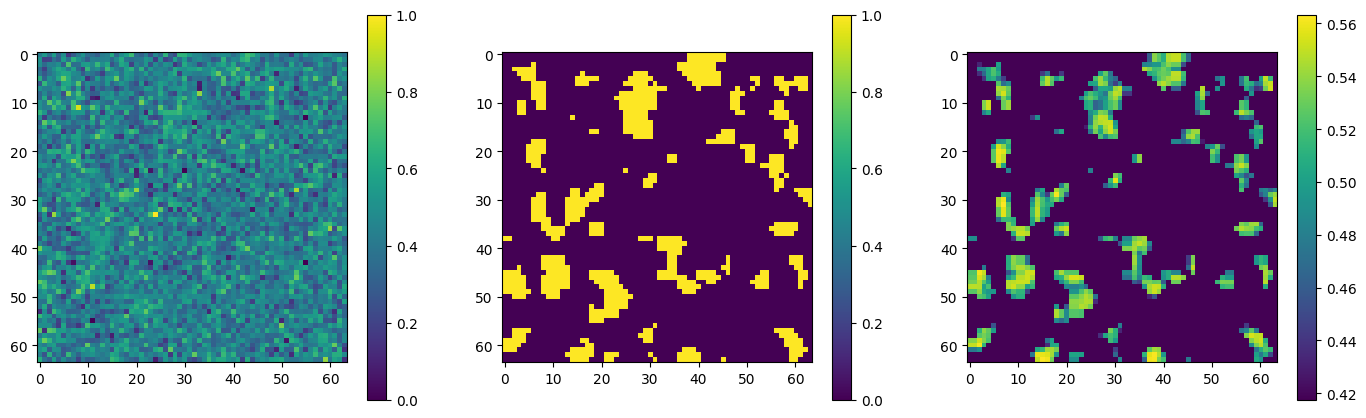

In [8]:
i = 0

plt.figure(figsize=(17,5))
plt.subplot(131)
plt.imshow(input_data[i])
plt.colorbar()
plt.subplot(132)
plt.imshow(labels_binary[i])
plt.colorbar()
plt.subplot(133)
plt.imshow(labels[i])
plt.colorbar()

In [9]:
len(input_data) == len(labels_binary)

True

In [10]:
dataset = tf.data.Dataset.from_tensor_slices((input_data, labels_binary))

2024-03-31 13:45:15.423091: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78746 MB memory:  -> device: 0, name: NVIDIA H100 PCIe, pci bus id: 0000:3a:00.0, compute capability: 9.0


In [11]:
len(dataset)

200100

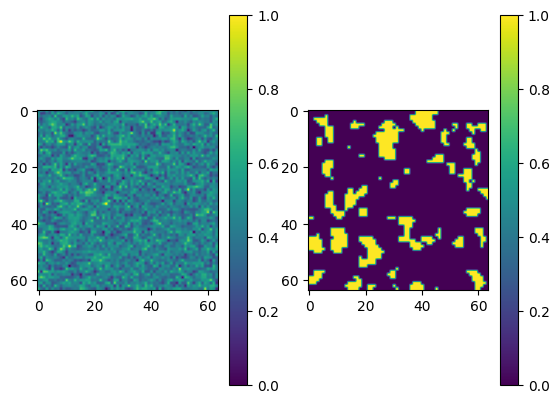

In [12]:
x, y = dataset.take(1).as_numpy_iterator().next()

plt.figure()
plt.subplot(121)
plt.imshow(x)
plt.colorbar()
plt.subplot(122)
plt.imshow(y)
plt.colorbar()
plt.show()


In [13]:
total_items = len(dataset)
train_size = int(0.9 * total_items)
val_size = int(0.095 * total_items)
test_size = total_items - train_size - val_size

print(train_size)
print(val_size)
print(test_size)

dataset_shuffled = dataset.shuffle(buffer_size=len(dataset))

train_dataset = dataset_shuffled.take(train_size).batch(32)
val_dataset = dataset_shuffled.skip(train_size).take(val_size).batch(32)
test_dataset = dataset_shuffled.skip(train_size).skip(val_size).batch(32)

180090
19009
1001


In [14]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.layers import Input, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau




def decoder_block(input_tensor, skip_features, n_filters, kernel_size=(3,3), batch_norm=True):
    # Transposed convolution (upsampling)
    x = Conv2DTranspose(n_filters, kernel_size, strides=(2, 2), padding='same')(input_tensor)
    # Concatenate with the corresponding output of the encoder (skip connection)
    x = concatenate([x, skip_features])
    # Convolutional layers with batch normalization and activation
    x = Conv2D(n_filters, kernel_size, padding='same')(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(n_filters, kernel_size, padding='same')(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    return x

def build_unet(input_shape=(64, 64, 1), n_filters=16, batch_norm=True):
    inputs = Input(input_shape)

    # Encoder: contracting path
    c1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(n_filters*2, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(n_filters*2, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(n_filters*4, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(n_filters*4, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(n_filters*8, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(n_filters*8, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(n_filters*12, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(n_filters*12, (3, 3), activation='relu', padding='same')(c5)
    p5 = MaxPooling2D((2, 2))(c5)

    c6 = Conv2D(n_filters*16, (3, 3), activation='relu', padding='same')(p5)
    c6 = Conv2D(n_filters*16, (3, 3), activation='relu', padding='same')(c6)

    # Decoder: expansive path
    d7 = decoder_block(c6, c5, n_filters*12, batch_norm=batch_norm)
    d8 = decoder_block(d7, c4, n_filters*8, batch_norm=batch_norm)
    d9 = decoder_block(d8, c3, n_filters*4, batch_norm=batch_norm)
    d10 = decoder_block(d9, c2, n_filters*2, batch_norm=batch_norm)
    d11 = decoder_block(d10, c1, n_filters, batch_norm=batch_norm)

    # Output
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d11)

    # Model
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Build U-Net model
unet_model = build_unet()
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [18]:
callbacks = [
    ModelCheckpoint('model_unet.keras', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=15, verbose=1, mode='min', min_lr=1e-6)
]

history = unet_model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/100
5628/5628 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8629 - loss: 0.3317
Epoch 1: val_loss improved from inf to 0.32215, saving model to model_unet.keras
5628/5628 ━━━━━━━━━━━━━━━━━━━━ 123s 22ms/step - accuracy: 0.8629 - loss: 0.3317 - val_accuracy: 0.8654 - val_loss: 0.3221 - learning_rate: 0.0010
Epoch 2/100
5628/5628 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8688 - loss: 0.3162
Epoch 2: val_loss did not improve from 0.32215
5628/5628 ━━━━━━━━━━━━━━━━━━━━ 106s 19ms/step - accuracy: 0.8688 - loss: 0.3162 - val_accuracy: 0.8145 - val_loss: 0.4108 - learning_rate: 0.0010
Epoch 3/100
5628/5628 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8695 - loss: 0.3145
Epoch 3: val_loss improved from 0.32215 to 0.31540, saving model to model_unet.keras
5628/5628 ━━━━━━━━━━━━━━━━━━━━ 110s 20ms/step - accuracy: 0.8695 - loss: 0.3145 - val_accuracy: 0.8690 - val_loss: 0.3154 - learning_rate: 0.0010
Epoch 4/100
5628/5628 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8701 - lo

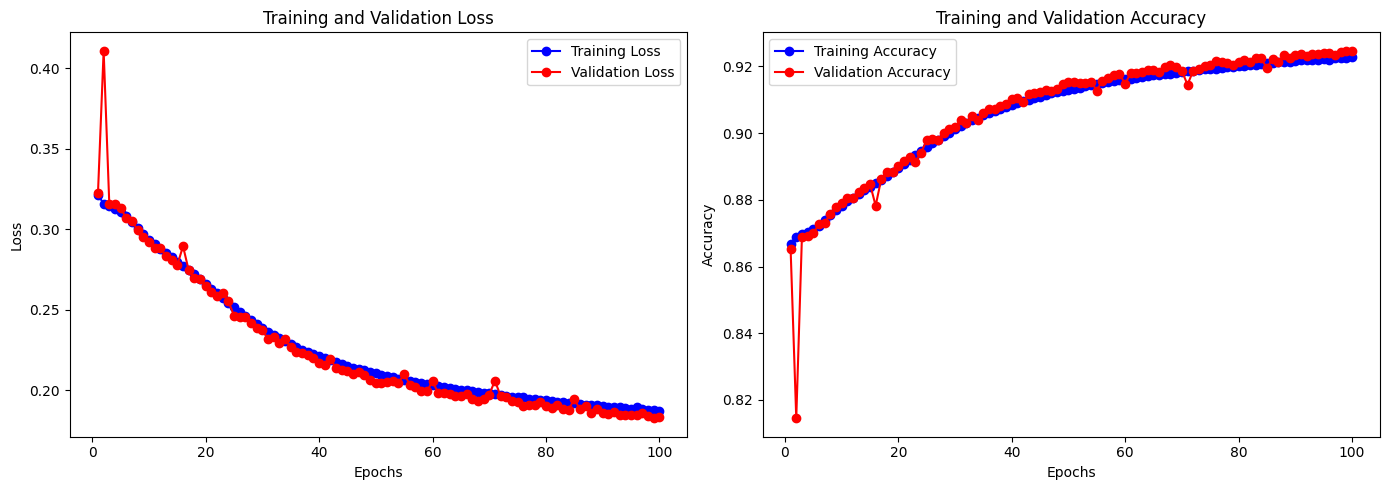

In [19]:
history_dict = history.history

# Loss Values
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# Accuracy Values - replace 'accuracy' with 'acc' if using a different version
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)

# Plotting
plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_values, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_values, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


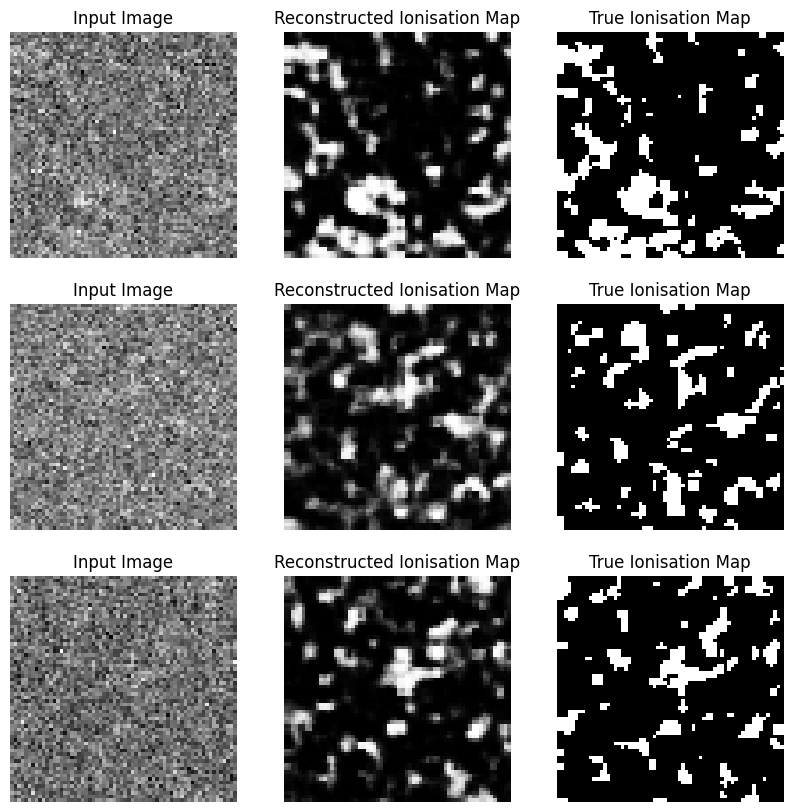

2024-03-31 17:12:25.735479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<Figure size 640x480 with 0 Axes>

In [22]:
for test_images, test_labels in test_dataset.take(1):
    predictions = unet_model.predict(test_images)
    plt.figure(figsize=(10, 10))
    for i in range(3):  # Display a few images from the batch
        plt.subplot(3, 3, i*3+1)
        plt.imshow(test_images[i].numpy().squeeze(), cmap='gray')
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(3, 3, i*3+2)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title("Reconstructed Ionisation Map")
        plt.axis('off')

        plt.subplot(3, 3, i*3+3)
        plt.imshow(test_labels[i].numpy().squeeze(), cmap='gray')
        plt.title("True Ionisation Map")
        plt.axis('off')
    plt.show()
    plt.savefig('preds.jpg')